## Data Exploration

For this tutorial, we aim to implement a Bayesian neural network using the MC Dropout technique to predict profit rates for the lending club loan data. Because a Bayesian neural network provides a distribution of probabilities, rather than a point estimate, we are able to use this distribution to then calculate measures including kurtosis, skewness, and variance. Later in this blog post, these measures will then be used to interpret the results.

### Lending Club Loan Data
The lending club loan data set (accessible on kaggle.com: https://www.kaggle.com/wendykan/lending-club-loan-data) contains data for loans in the period of 2007 - 2015. It includes, among others, information about current payments, the loan status (current, late, fully paid etc.) and data about the borrower such as state, annual income and home ownership. The complete data set consists of approximately 890.000 rows and 74 columns.

Before we implement the Bayesian neural network, we will explore and clean the data. Because we are only interested in past loans, we have already created a new data set, for which we removed loans where the loan status is "current". We now have a data set with 285,600 rows and 74 columns.

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
loan = pd.read_csv("data/loans_Past.csv", low_memory=False)

In [4]:
print(loan.shape)
loan.head()

(285600, 74)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The first few rows of the data set show that some of the columns seem to have quite a lot of missing values.
In order to obtain a better overview, we start by creating a data set `loan_missing` which contains boolean values for missing data. We then sum those missing values by column and calculate the percentage. Lastly, we order the dataframe by the percentage of missing values, with the highest percentage on top.

In [18]:
loan_missing = loan.isna()
loan_missing_count = loan_missing.sum()

loan_missing_percentage = (loan_missing_count / len(loan)).round(4) * 100
loan_missing_sorted = loan_missing_percentage.sort_values(ascending=False)
loan_missing_sorted.head(20)

dti_joint                      99.98
verification_status_joint      99.98
annual_inc_joint               99.98
il_util                        97.50
mths_since_rcnt_il             97.19
max_bal_bc                     97.12
open_rv_24m                    97.12
open_rv_12m                    97.12
all_util                       97.12
total_bal_il                   97.12
open_il_24m                    97.12
open_il_12m                    97.12
open_il_6m                     97.12
open_acc_6m                    97.12
total_cu_tl                    97.12
inq_fi                         97.12
inq_last_12m                   97.12
next_pymnt_d                   88.58
mths_since_last_record         86.81
mths_since_last_major_derog    80.24
dtype: float64

The resulting table proves that a lot of columns are almost completely empty. For further data exploration, we set a threshold of 50% and remove each column above this threshold. We now have 52 columns left.

In [6]:
temp = [i for i in loan.count()<len(loan)*0.50]
loan.drop(loan.columns[temp],axis=1,inplace=True)
loan.shape

(285600, 52)

Since there is no profit column existing in our data set yet, we define a target variable `profit` containing the profit rate of each loan. Then we have a look at the distribution of profits in order to find out if there are any imbalances in our target variable. We classify the target values as positive / negative profit and count the occurences in each class.

In [7]:
loan["profit"] = loan.apply(lambda x: ((x['total_pymnt'] - x['loan_amnt'])/x['loan_amnt']), axis = 1)
loan["profit"] = loan["profit"].round(2)

target_class = pd.DataFrame(columns=["class"])
target_class["class"] = [1 if i > 0 else 0 for i in loan["profit"]]
target_class["class"].value_counts()

1    208985
0     76615
Name: class, dtype: int64

The profit classes show that there are far more instances of positive profit than negative profit, meaning that our data set is imbalanced. In order to avoid a biased prediction, we will need to balance the data later on in the tutorial.
Now, we will have a look at what variables have the highest positive and negative correlation with our target variable.

In [8]:
loan.head()
corr = loan.corr()["profit"].sort_values(ascending=False)
print('most positive correlations:\n', corr.head(10))

print('most negative correlations:\n', corr.tail(10))

most positive correlations:
 profit              1.000000
total_rec_prncp     0.551126
total_pymnt         0.515352
total_pymnt_inv     0.510558
last_pymnt_amnt     0.362307
total_rec_int       0.218768
tot_cur_bal         0.040476
annual_inc          0.020393
total_rev_hi_lim    0.004064
inq_last_6mths      0.000856
Name: profit, dtype: float64
most negative correlations:
 loan_amnt                 -0.079100
int_rate                  -0.100841
collection_recovery_fee   -0.137428
dti                       -0.146143
recoveries                -0.229157
id                        -0.481423
member_id                 -0.482082
out_prncp                 -0.543330
out_prncp_inv             -0.543338
policy_code                     NaN
Name: profit, dtype: float64


The columns `total_rec_prncp` (prinicpal received to date),`total_pymnt` (payments received to date for total amount funded) and`total_pymnt_inv` (payments received to date for portion of total amount funded by investors) have the highest positive correlation with our target column. The columns`out_prncp` (remaining outstanding principal for total amount funded) and `out_prncp_i` (remaining outstanding principal for portion of total amount funded by investors) have the highest negative correlation with the target column.

This certainly seems feasible for our past loans, but if we think about using the model for real world predictions, these variables may not be as significant.

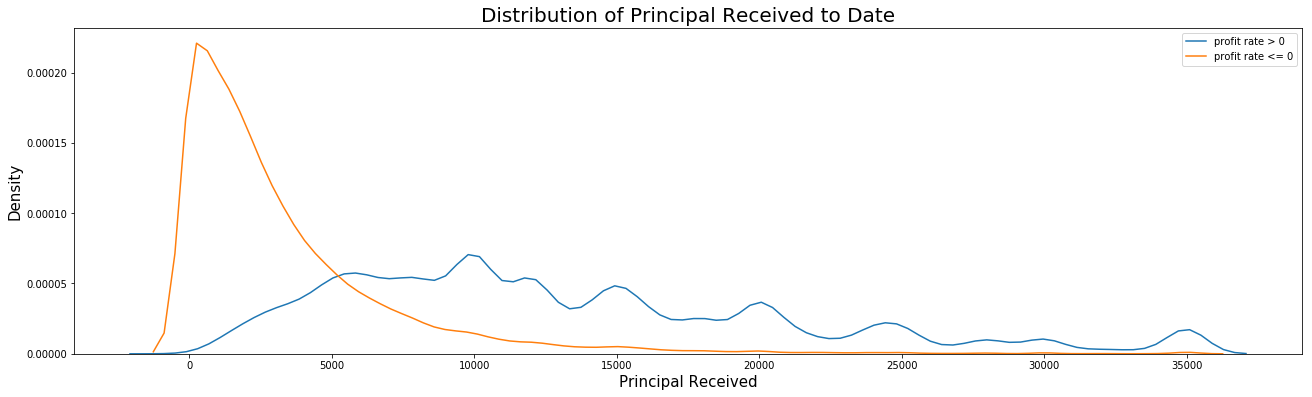

In [9]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(loan.loc[loan['profit'] > 0, 'total_rec_prncp'], label = 'profit rate > 0')
sns.kdeplot(loan.loc[loan['profit'] <= 0, 'total_rec_prncp'], label = 'profit rate <= 0');
plt.xlabel('Principal Received',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Principal Received to Date',fontsize=20);

The distribution of principal received to date shows that most instances with negative profits appear in the range of 0 - 10,000$, whereas instances with positive profits are more widely distributed. Next, we will see if there are any borrowers who have taken more than one loan to see if their member ID could be an indicator of the profit rate.

In [10]:
loan['member_id'].value_counts().head()

1415743     1
11967366    1
34691966    1
2708351     1
40483058    1
Name: member_id, dtype: int64

There are no members who have taken more than one loan. Consequently, the member id does not indicate whether the borrower is likely to pay back their loan. Hence, the column does not need to be considered for predictions.

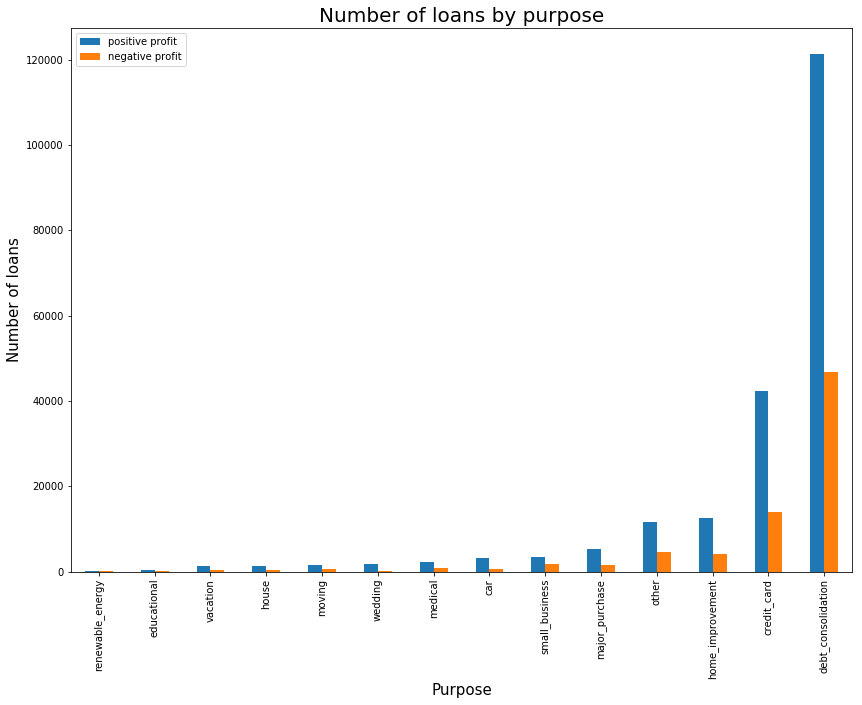

In [11]:
profit_by_purpose = pd.DataFrame(loan[loan['profit']>0].groupby('purpose')['profit'].count().sort_values())
profit_by_purpose["profit_neg"] = pd.DataFrame(loan[loan['profit']<=0].groupby('purpose')['profit'].count().sort_values())["profit"]

fig, ax = plt.subplots(figsize=(14, 10))
profit_by_purpose.plot(kind="bar", ax=ax)
plt.ylabel('Number of loans',fontsize=15)
plt.xlabel('Purpose',fontsize=15)
plt.title('Number of loans by purpose', fontsize=20);
L=plt.legend()
L.get_texts()[0].set_text('positive profit')
L.get_texts()[1].set_text('negative profit')

The barplot shows the number of loans issued per purpose category. Most loans are issued for debt consolidation and credit cards - these are also the categories with the highest amount of loans with negative profit. There is no category where the amount of loans with negative profits exceeds loans with positive profits. However, there certainly are categories where the share of negative profits is very small, such as house, car or wedding.

### Splitting the Data Set

In order to obtain comparable results, we split the loan data set into a test set with 40k rows, and five diffrent training sets with 60k, 100k, 150k, 200k and 240k rows. To do this, we use the `train_test_split()` function by `sklearn`. Furthermore, we add the profit rate directly into the data set as our target variable. We save each data set as a csv file for later use. 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

loan_past = pd.read_csv("data/loans_Past.csv", low_memory=False)
loan_past = loan_past.dropna(axis=1, how='any')

target = loan_past.apply(lambda x: ((x['total_pymnt'] - x['loan_amnt'])/x['loan_amnt']), axis = 1)

x_train_240k, x_test_40k, y_train_240k, y_test_40k = train_test_split(loan_past, target, test_size=40000, random_state=42)
x_train_200k, x_test_rm, y_train_200k, y_test_rm = train_test_split(x_train_240k, y_train_240k, test_size=40000, random_state=28)
x_train_150k, x_test_rm_2, y_train_150k, y_test_rm_2 = train_test_split(x_train_200k, y_train_200k, test_size=50000, random_state=3)
x_train_100k, x_test_rm_3, y_train_100k, y_test_rm_3 = train_test_split(x_train_150k, y_train_150k, test_size=50000, random_state=49)
x_train_60k, x_test_rm_4, y_train_60k, y_test_rm_4 = train_test_split(x_train_100k, y_train_100k, test_size=40000, random_state=12)

x_test_40k.to_csv("test_set_40k.csv", index=False)
x_train_240k.to_csv("train_set_240k.csv", index=False)
x_train_200k.to_csv("train_set_200k.csv", index=False)
x_train_150k.to_csv("train_set_150k.csv", index=False)
x_train_100k.to_csv("train_set_100k.csv", index=False)
x_train_60k.to_csv("train_set_60k.csv", index=False)

## Implementation

Now that we have an overview of the data and defined fixed data sets for testing and training, we will implement a Bayesian neural network using the MC Dropout technique to predict profit rates for the lending club data. The model will be based on `keras`, a deep learning library for Python. For pre-processing the data we will use `klearn` as well as `imblearn`.

In [ ]:
import pandas as pd
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from keras import Model as mcModel
from keras import Input as mcInput
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

We start by reading in our data sets. We have prepared the data by splitting the data set into a test data set with 40k rows and multiple training data sets with 60k, 100k, 150k, 200k and 240k rows, respectively. This way, we ensure that the same data is used on each model and the results are comparable. For splitting the data, we used the function `train_test_split()` by sklearn.

For easy access, we create a list of the file names of the data sets. Then we read each file using a for loop, and save the data in a dictionary using the file name as a key.

In [ ]:
data_sets = ["test_set_40k", "train_set_60k", "train_set_100k", 
             "train_set_150k", "train_set_200k", "train_set_240k"]

data = {} 
for item in data_sets:
    file = pd.read_csv("data/" + item + ".csv")
    data[item] = file

### Pre-Processing

First, we implement a function to pre-process the data according to our findings in the data exploration section. The first step is to drop any missing data. As mentioned above, our data set is imbalanced. A solution to balancing data sets is to use the SMOTE (Synthetic Minority Over-sampling Technique) function provided by `imblearn`. SMOTE generates synthetic data points to oversample the minority class. However, SMOTE usually cannot be used for regression problems. For this reason, we have to temporarily change our target variable to a classification problem. We classify our profit rates into negative profits and positive profits, and apply the SMOTE function on those classes. We use profit rate as an additional feature instead. After oversampling, we simply drop the profit classes and re-define the profit rate as the target variable. Since SMOTE is only applied to training data, we included a boolean parameter to switch SMOTE on and off. In the case of test data, we simply define our features and target variable.

Lastly, we scale the data using `StandardScaler()` provided by `sklearn`.

In [ ]:
def preprocess(train_data, smote = True):
    train_data = train_data.dropna()
    
    if smote:
        features = train_data[['int_rate','loan_amnt', 'purpose', 'dti','term','grade', 'profit_rate']]
        features = pd.get_dummies(features)
        target = [1 if i > 0 else 0 for i in features['profit_rate']]
        
        sm = SMOTE(random_state = 43, ratio = 'minority')
        x_feat_1, x_targ_1 = sm.fit_sample(features, target)
        
        x_features = pd.DataFrame(x_feat_1)
        x_features.columns = features.columns
        x_target = x_features[["profit_rate"]]
        x_features = x_features.drop("profit_rate", axis=1)
        
    else:
        x_features = train_data[['int_rate','loan_amnt', 'purpose', 'dti','term','grade']]
        x_features = pd.get_dummies(x_features)
        x_target = train_data[['profit_rate']]

    scaler_features = preprocessing.StandardScaler().fit(x_features)
    x_features = scaler_features.transform(x_features)
  
    scaler_target = preprocessing.StandardScaler().fit(x_target)
    x_target = scaler_target.transform(x_target)
  
    return x_features, x_target

### Model

The following function defines the architecture of our model. It passes the following five parameters:
 -  *model_type*: the type of our model. For now, we only implement the mcDropout option, but this could easily be extended with more model types.
 - *n_hidden*: a vector containing the number of neurons for each hidden layer
 - *input_dim*: the number of input dimensions, which is equal to the number of columns in our training set
 - *dropout_prob*: the dropout probability for the dropout layers in the neural network. The value should usually be between 0.05 - 0.5
 - *reg*: used for regularization during dropout

Next, we instantiate our model. We start with the input layer using the keras `Input()` function and pass the input dimensions. Using `Dropout()`, we apply the dropout technique to our inputs. Lastly, we instatiate a regular densely-connected layer using the `Dense()` function. Here we pass the dimensionality as an argument using the first value of the `n_hidden` vector. We use the ReLu (Reactive linear unit) activation function and pass the regularization function, which will be explained in more detail below. We use a weight regularizer (called `W_regularizer`), with the l2 weight regularization penalty - this corresponds to the weight decay. 

Now, for each hidden layer (using the length of the `n_hidden` vector), we instantiate the dropout function and a dense layer, as described above. Lastly, we create the output layer in the same way. The dimensionality of our output layer is one, since we only predict one target variable - the profit rate.

In [ ]:
def architecture(model_type, n_hidden, input_dim, dropout_prob, reg):
      if model_type == 'mcDropout':
        inputs = mcInput(shape=(input_dim,))
        inter = Dropout(dropout_prob)(inputs, training=True)
        inter = Dense(n_hidden[0], activation='relu',
                      W_regularizer=l2(reg))(inter)
        for i in range(len(n_hidden) - 1):
            inter = Dropout(dropout_prob)(inter, training=True)
            inter = Dense(n_hidden[i+1], activation='relu',
                            W_regularizer=l2(reg))(inter)
        inter = Dropout(dropout_prob)(inter, training=True)
        outputs = Dense(1, W_regularizer=l2(reg))(inter) 
        model3 = mcModel(inputs, outputs)
        return model3

In the following step, we define a function that runs our model. Before we do so, we pre-process our test data so we can use it as a default argument for our predictions.

The function `model_runner()` takes the following arguments: 
 - *X_train/y_train*: the training data
 - *X_test/y_test*: the test data, using the 40k test set as a default
 - *dropout_prob*: the dropout probability, which is then passed on to the model
 - *n_epochs*: the number of epochs 
 - *tau*: tau value used for regularization
 - *batch_size*: the size of the batches used for fitting the model
 - *lengthscale*: the prior length scale
 - *n_hidden*: a vector containing the number of neurons per layer, which is passed on to the model as well

We now define the input dimension to equal the number of columns in the training set. We also define a value `N`, which corresponds to the number of rows in the training set and is used for the regularization function. The regularization is carried out in a variable `reg`. The regularization function used here is the same function we introduced in the theory part, section Monte Carlo Dropout.
Now we simply build the model using the `architecture()` function implemented above. `Compile()` configures the model for training. We then train our model using the function `fit()`, where we pass our training data, as well as the batch size and the number of epochs. The argument `verbose = 1` results in a progress bar being shown during training. 

In [ ]:
test_features, test_target = preprocess(data['test_set_40k'], smote=False)
def model_runner(X_train, y_train, X_test=test_features, y_test=test_target,
                dropout_prob=0.20, n_epochs=100, tau=1.0, batch_size=500, 
                lengthscale=1e-2, n_hidden=[100,100]):
  
    input_dim = X_train.shape[1]
    N = X_train.shape[0]
    reg = lengthscale**2 * (1 - dropout_prob) / (2. * N * tau)


    print('McDropout NN fit')

    model_mc_dropout = architecture(model_type = 'mcDropout', 
                                    n_hidden=n_hidden, input_dim=input_dim, 
                                    dropout_prob=dropout_prob, reg=reg)
    model_mc_dropout.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    model_mc_dropout.fit(X_train, y_train, batch_size=batch_size, nb_epoch=n_epochs, verbose=1)


    return model_mc_dropout

### Prediction

It is now time to use the model to make predictions. We implement another function called `predictor()`, which takes the following arguments:
 - *model_mc_dropout*: the dropout model
 - *X_test/y_test*: the test data
 - *T*: the number of predictions made for each observation

We now use `T` in a for loop to run the predictions as many times as we specified. The results are added to a list called `probs_mc_dropout`. This results in a two-dimensional list with `T` items in each list. In other words, for each row in the test set, we now have a set of `T` predictions, enabling us to calculate uncertainty, and other measures such as variance, mean or skewness.

In [ ]:
def predictor(model_mc_dropout, 
              X_test=test_features, y_test = test_target, T = 1000):
    probs_mc_dropout = []
    for _ in range(T):
        probs_mc_dropout += [model_mc_dropout.predict(X_test,verbose=1)]
    predictive_mean = np.mean(probs_mc_dropout, axis=0)
    predictive_variance = np.var(probs_mc_dropout, axis=0)
    mse_mc_dropout = mean_squared_error(predictive_mean, y_test)
    print(mse_mc_dropout)
  
    return probs_mc_dropout

In order to evaluate the results, we save the predictions for each test-run in a pickle file. This is done by the following function. The necessary parameters are:
 - predictions: the two-dimensional array of predictions
 - filename: a name for the file the predictions are saved in

In [ ]:
def pred_to_pickle(predictions, filename):
    outfile = open('pred_'+filename+'.pickle','wb')
    pickle.dump(predictions, outfile)
    outfile.close()

We now iterate over the data dictionary and make predictions for the test set, using another training set each time. We save the results, which will be used for evaluation in the following section.

In [ ]:
for filename, training_set in data.items():
        features, target = preprocess(training_set)
        model = model_runner(features, target)
        probs = predictor(model)
        pred_to_pickle(probs, filename)